In [ ]:
# import gdown
# from pyro.infer import SVI, JitTrace_ELBO, Trace_ELBO, TraceGraph_ELBO
# from pyro.optim import Adam
# import os
# import pyro
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import anndata as ad
import re
import pyro.distributions as pyrodist
import scanpy as sc
import seaborn as sns
from datetime import datetime
import time
import toolz
import torch
import torch.utils.data
import torchvision.utils as vutils
import umap
import skimage as skim
from abc import abstractmethod
from anndata.experimental.pytorch import AnnLoader
from importlib import reload
from math import pi, sin, cos, sqrt, log
import sklearn
from sklearn import datasets as skds
from sklearn.cluster import KMeans
from sklearn.metrics.cluster import normalized_mutual_info_score
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn import mixture
from toolz import partial, curry
from toolz import groupby, count, reduce, reduceby, countby, identity
from torch import nn, optim, distributions, Tensor
from torch.nn.functional import one_hot
from torchvision import datasets, transforms, models
from torchvision.utils import save_image, make_grid
from typing import Callable, Iterator, Union, Optional, TypeVar
from typing import List, Set, Dict, Tuple
from typing import Mapping, MutableMapping, Sequence, Iterable
from typing import Union, Any, cast, IO, TextIO
from torch.utils.data import WeightedRandomSampler
from scipy import stats
# my own sauce
from my_torch_utils import denorm, normalize, mixedGaussianCircular
from my_torch_utils import fclayer, init_weights, buildNetwork
from my_torch_utils import fnorm, replicate, logNorm, log_gaussian_prob
from my_torch_utils import plot_images, save_reconstructs, save_random_reconstructs
from my_torch_utils import scsimDataset
import my_torch_utils as ut
from importlib import reload
from torch.nn import functional as F
import gmmvae03 as M3
import gmmvae04 as M4
import gmmvae05 as M5
import gmmvae06 as M6
import gmmvae07 as M7
import gmmvae08 as M8
import gmmvae09 as M9
import gmmvae10 as M10
import gmmvae11 as M11
import gmmvae12 as M12
import gmmvae13 as M13
import gmmvae14 as M14
import gmmvae15 as M15
import gmmvae16 as M16
import gmmvaeBeta00 as Mb0
import gmmTraining as Train

print(torch.cuda.is_available())

#plt.ion()
#sc.settings.verbosity = 3
#sc.logging.print_header()
# sc.settings.set_figure_params(dpi=120, facecolor='white', )
# sc.settings.set_figure_params(figsize=(8,8), dpi=80, facecolor='white', )
sc.settings.set_figure_params(
    dpi=80,
    facecolor="white",
)

In [ ]:
adata = sc.read_h5ad("./data/scgen/scGen_datasets/train_study.h5ad")
bdata = sc.read_h5ad("./data/scgen/scGen_datasets/valid_study.h5ad")
adata.X = adata.X.toarray()
bdata.X = bdata.X.toarray()

In [3]:
sc.pp.neighbors(adata,)
sc.pp.pca(adata,)
sc.tl.umap(adata,)
sc.tl.louvain(adata,)

In [96]:
sc.pp.neighbors(bdata,)
sc.pp.pca(bdata,)
sc.tl.umap(bdata,)
sc.tl.louvain(bdata,)

In [4]:
enc_labels = LabelEncoder()
labels = enc_labels.fit_transform( adata.obs["cell_type"],)
labels = F.one_hot(torch.tensor(labels)).float()
enc_conds = LabelEncoder()
conditions = enc_conds.fit_transform(adata.obs["condition"],)
conditions = F.one_hot(torch.tensor(conditions)).float()
data = torch.tensor(adata.X)

test_enc_labels = LabelEncoder()
test_labels = test_enc_labels.fit_transform( bdata.obs["cell_type"],)
test_labels = F.one_hot(torch.tensor(test_labels)).float()
test_enc_conds = LabelEncoder()
test_conditions = test_enc_conds.fit_transform(bdata.obs["condition"],)
test_conditions = F.one_hot(torch.tensor(test_conditions)).float()
test_data = torch.tensor(bdata.X)

In [6]:
adata.obs["label"] = enc_labels.inverse_transform(
    labels.argmax(-1).detach().numpy(),
)
bdata.obs["label"] = test_enc_labels.inverse_transform(
    test_labels.argmax(-1).detach().numpy(),
)
adata.obs

,cell_type,condition,mt_frac,n_counts,n_genes,percent_mito,study,louvain,label
index,,,,,,,,,
AAACATACCAAGCT-1-stimulated-0,NK cells,stimulated,0.0,1158.0,589,NaN,Kang et al,3,NK cells
AAACATACCCCTAC-1-stimulated-0,Dendritic cells,stimulated,0.0,1722.0,795,NaN,Kang et al,16,Dendritic cells
AAACATACCCGTAA-1-stimulated-0,CD4 T cells,stimulated,0.0,1360.0,585,NaN,Kang et al,2,CD4 T cells
AAACATACCCTCGT-1-stimulated-0,B cells,stimulated,0.0,1438.0,732,NaN,Kang et al,5,B cells
AAACATACGAGGTG-1-stimulated-0,CD4 T cells,stimulated,0.0,1233.0,546,NaN,Kang et al,2,CD4 T cells
...,...,...,...,...,...,...,...,...,...
TTTGACTGGCGGAA-1-control-0,CD8 T cells,control,0.0,2503.0,821,NaN,Kang et al,6,CD8 T cells
TTTGACTGTCGTAG-1-control-0,CD14+ Monocytes,control,0.0,3696.0,1101,NaN,Kang et al,12,CD14+ Monocytes
TTTGACTGTTACCT-1-control-0,CD14+ Monocytes,control,0.0,2108.0,629,NaN,Kang et al,1,CD14+ Monocytes


In [10]:
data_loader = torch.utils.data.DataLoader(
        dataset = ut.SynteticDataSetV2(
            [
                data,
                labels,
                conditions,
                ],),
            batch_size=128,
            shuffle=True,
)
test_loader = torch.utils.data.DataLoader(
        dataset = ut.SynteticDataSetV2(
            [
                test_data,
                test_labels,
                test_conditions,
                ],),
            batch_size=128,
            shuffle=True,
)

/home/ykolb/mambaforge/envs/torch/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/ykolb/mambaforge/envs/torch/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/ykolb/mambaforge/envs/torch/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


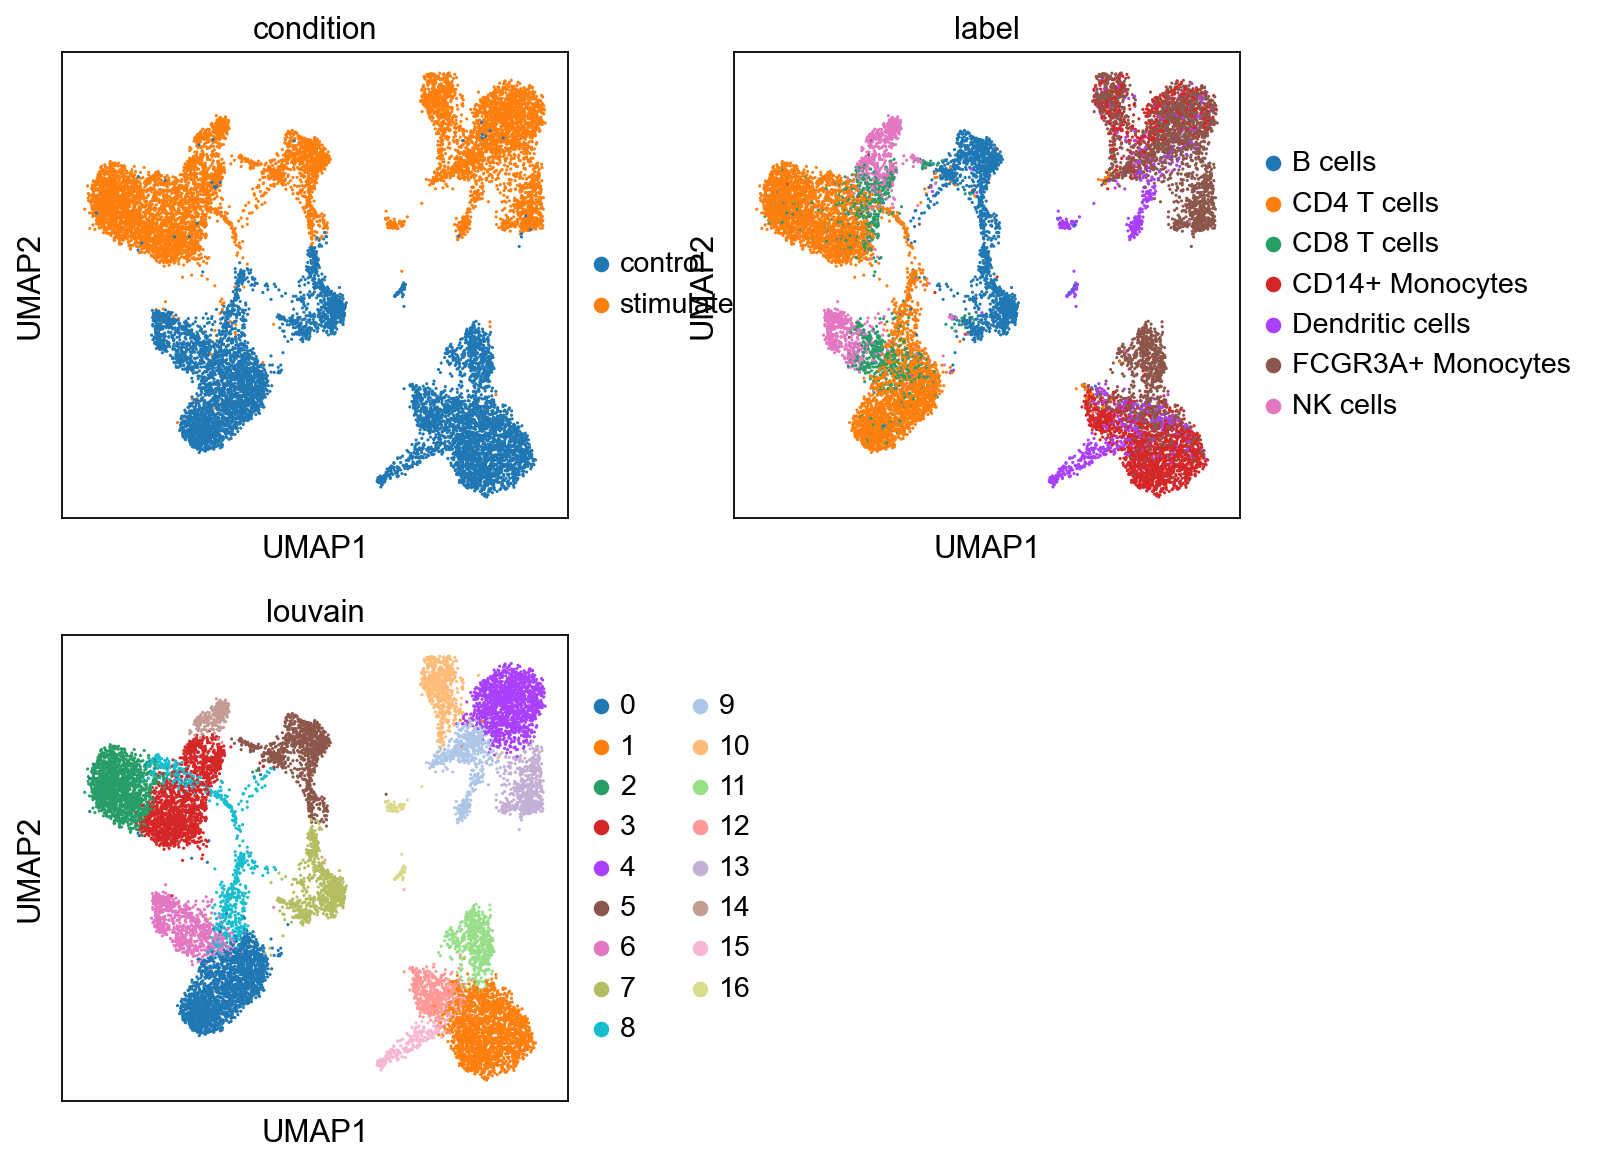

In [8]:
#fig, ax = plt.subplots(1,1)
sc.pl.umap(adata, ncols=2, 
           color=[
               #"cell_type",
               "condition",
               "label",
               "louvain",
           ],
           #title="PBMCs (Kang): UMAP (pca)", 
           save="_Kang_pca_umap.png",
           #show=True,
           #ax=ax,
          )


/home/ykolb/mambaforge/envs/torch/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/ykolb/mambaforge/envs/torch/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/ykolb/mambaforge/envs/torch/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


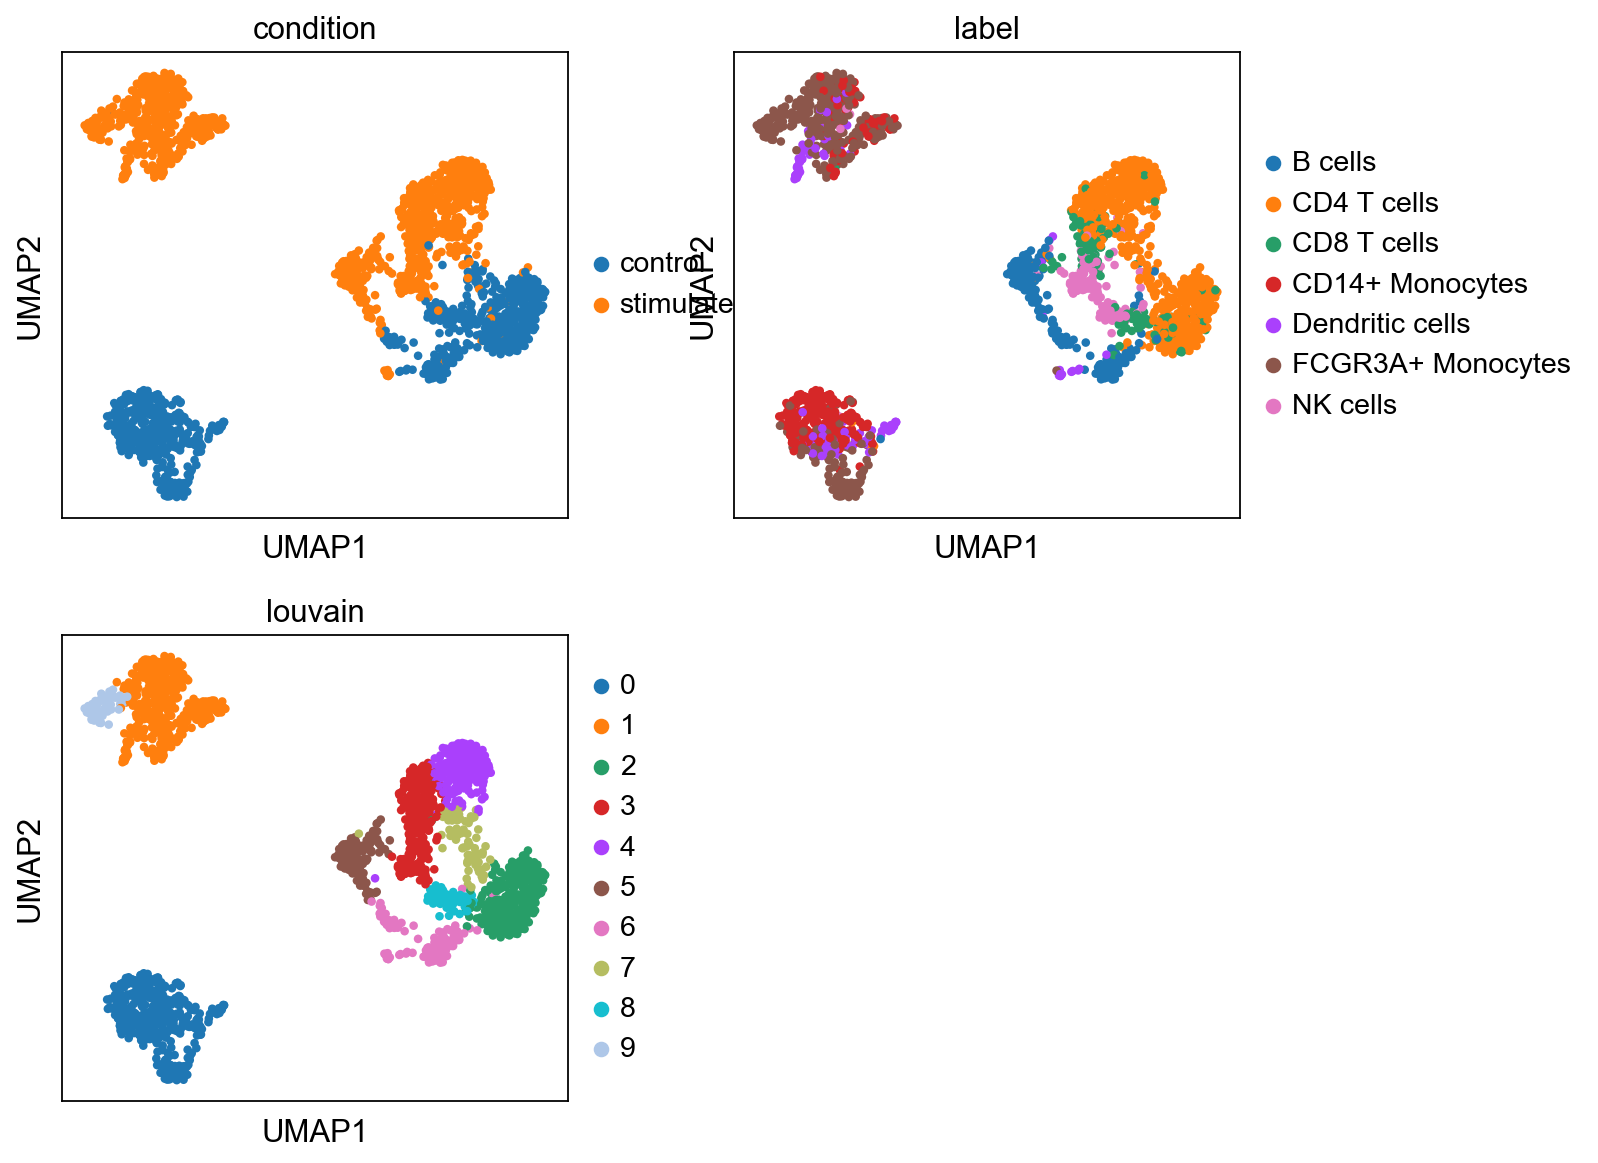

In [97]:
#fig, ax = plt.subplots(1,1)
sc.pl.umap(bdata, ncols=2, 
           color=[
               #"cell_type",
               "condition",
               "label",
               "louvain",
           ],
           #title="PBMCs (Kang): UMAP (pca)", 
           save="_Kang_pca_umap.png",
           #show=True,
           #ax=ax,
          )

In [19]:
model = Mb0.VAE_Dirichlet_GMM_TypeB1602xzC(
    nx=adata.n_vars,
    nz=24,
    nw=24,
    nclasses=labels.shape[1]*3,
    concentration=1e0,
    dropout=0.15,
    bn=True,
    reclosstype="mse",
    restrict_w=True,
    restrict_z=True,
    nc1=conditions.shape[1],
    #learned_prior=False,
    learned_prior=True,
    #positive_rec=True,
)
model.apply(init_weights)
print(model.__class__)

<class 'gmmvaeBeta00.VAE_Dirichlet_GMM_TypeB1602xzC'>


In [20]:
Train.basicTrainLoopCond(
    model,
    data_loader,
    test_loader,
    num_epochs=20,
    lrs = [
        1e-4,
        1e-3,
        1e-3,
        1e-3,
        1e-4,
        1e-5,
    ],
    report_interval=0,
    wt=0,
)

epoch's lr =  0.0001
epoch's lr =  0.001
epoch's lr =  0.001
epoch's lr =  0.001
epoch's lr =  0.0001
epoch's lr =  1e-05
done training


In [21]:
r,p,s = ut.estimateClusterImpurityLoop(model, test_data, test_labels, "cuda", )
print(p,r,s)
r = r[r>=0]
s = s[s>=0]
print((r*s).sum().item() / s.sum().item(), r.mean().item())

[5. 1. 2. 2. 1. 2. 0. 2. 2. 3. 6. 2. 2. 2. 2. 2. 5. 2. 2. 2. 6.] [0.77886978 0.77222222 1.         0.97297297 0.53571429 0.97
 0.89814815 0.87654321 0.83783784 0.66666667 0.63793103 0.8
 0.85185185 0.98198198 0.94444444 0.625      0.58823529 1.
 0.69902913 0.95049505 1.        ] [407. 180.   3.  37. 140. 100. 216.  81. 111.  72.  58.  15.  54. 111.
  18.  32. 102.   2. 103. 101.  57.]
0.8005 0.8279973288050325


In [22]:
model.cpu()
model.eval()
output = model(test_data, )
bdata.obs["predict"] =  output["q_y"].argmax(-1).detach().numpy().astype(str)
#bdata.obs["predict"] = test_enc_labels.inverse_transform(
#    output["q_y"].argmax(-1).detach().numpy(),
#)
bdata.obsm["mu_z"] = output["mu_z"].detach().numpy()
bdata.obsm["z"] = output["z"].detach().numpy()
bdata.obsm["mu_w"] = output["mu_w"].detach().numpy()
bdata.obsm["w"] = output["w"].detach().numpy()
rec = output["rec"].detach()
del output

In [23]:
print(torch.cosine_similarity(test_data, rec).mean())

tensor(0.7525)


In [24]:
sc.pp.neighbors(bdata, use_rep="mu_z",)
sc.pp.pca(bdata,)
sc.tl.umap(bdata,)
sc.tl.louvain(bdata,)

/home/ykolb/mambaforge/envs/torch/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/ykolb/mambaforge/envs/torch/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/ykolb/mambaforge/envs/torch/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/ykolb/mambaforge/envs/torch/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


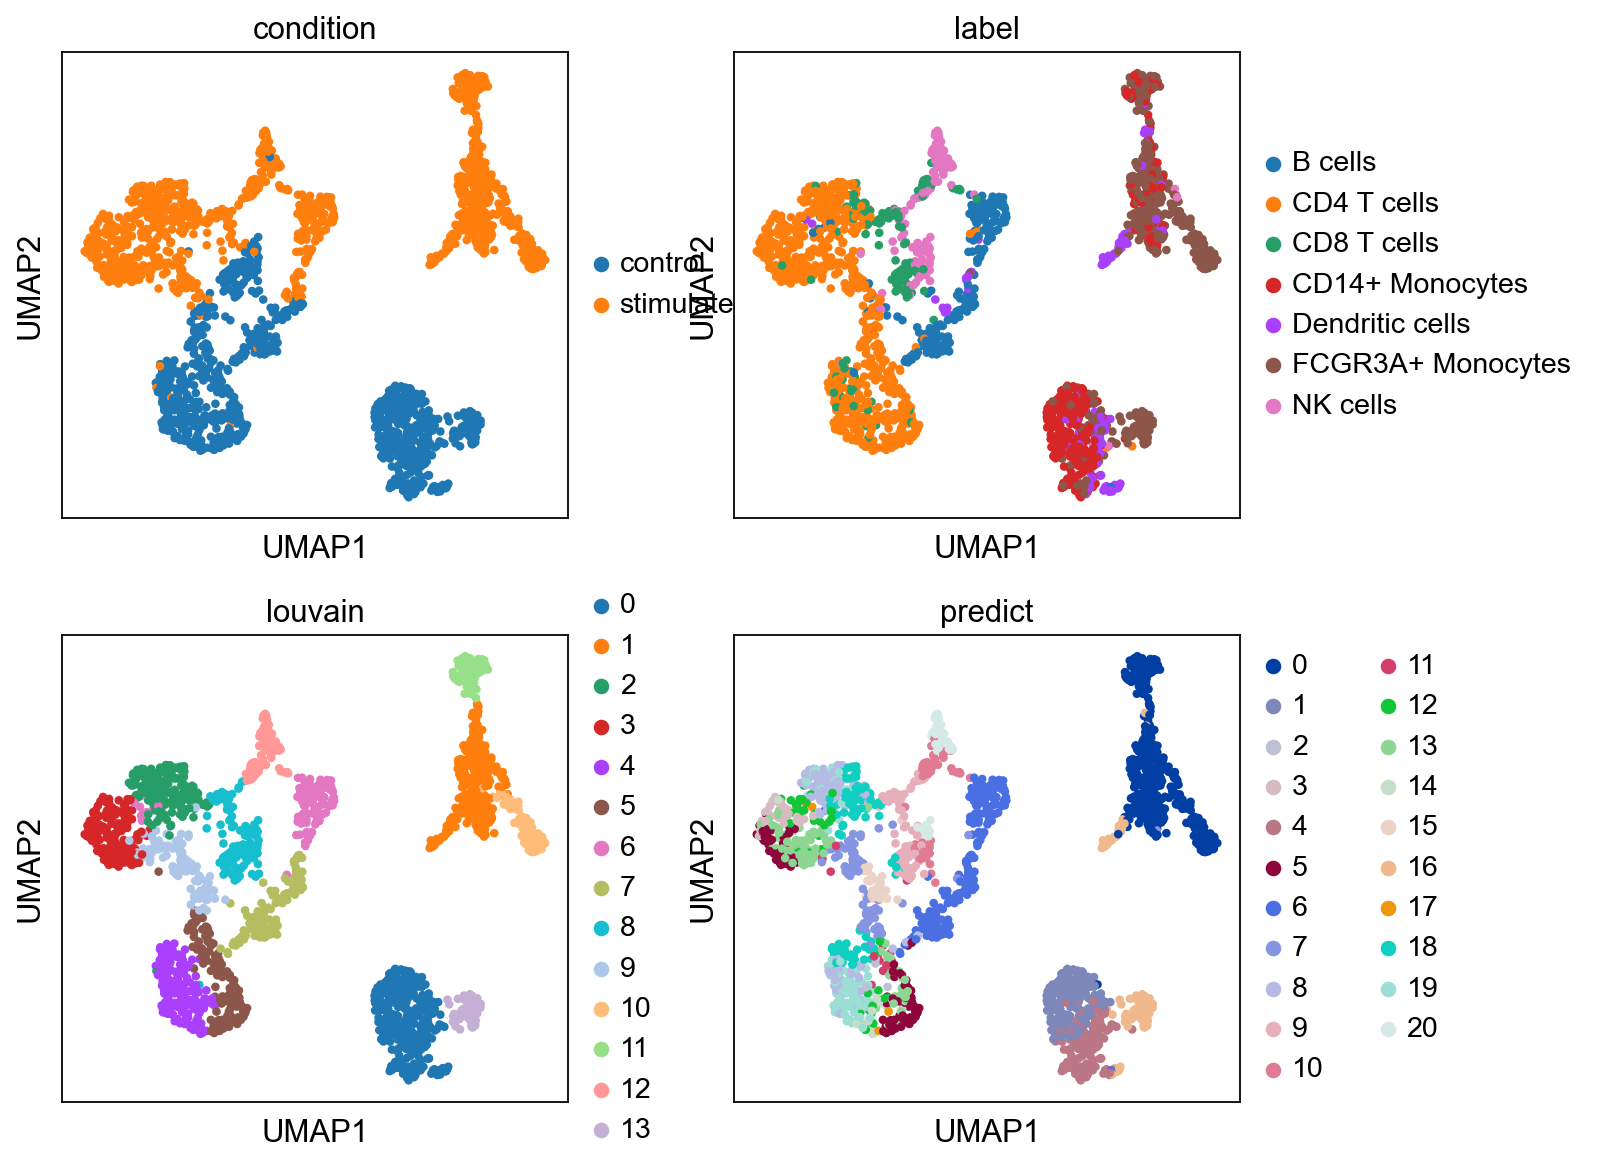

In [26]:
#fig, ax = plt.subplots(1,1)
sc.pl.umap(bdata, ncols=2, 
           color=[
               #"cell_type",
               "condition",
               "label",
               "louvain",
               "predict",
           ],
           #title="PBMCs (Kang): UMAP (pca)", 
           #save="_Kang_pca_umap.png",
           #show=True,
           #ax=ax,
          )


In [39]:
reload(Mb0)
#0.8
model = Mb0.VAE_Dirichlet_GMM_TypeB1602zC(
    nx=adata.n_vars,
    nz=24,
    nw=24,
    nclasses=labels.shape[1]*3,
    concentration=1e0,
    dropout=0.15,
    bn=True,
    reclosstype="mse",
    restrict_w=True,
    restrict_z=True,
    nc1=conditions.shape[1],
    #learned_prior=False,
    learned_prior=True,
    #positive_rec=True,
)
model.apply(init_weights)
print(model.__class__)

True
<class 'gmmvaeBeta00.VAE_Dirichlet_GMM_TypeB1602zC'>


In [63]:
model = Mb0.VAE_Dirichlet_GMM_TypeB1602zC(
    nx=adata.n_vars,
    nz=12,
    nw=12,
    nclasses=labels.shape[1]*3,
    concentration=1e0,
    dropout=0.15,
    bn=True,
    reclosstype="mse",
    restrict_w=True,
    restrict_z=True,
    nc1=conditions.shape[1],
    learned_prior=False,
    #learned_prior=True,
    #positive_rec=True,
)
model.apply(init_weights)
print(model.__class__)

<class 'gmmvaeBeta00.VAE_Dirichlet_GMM_TypeB1602zC'>


In [64]:
Train.basicTrainLoopCond(
    model,
    data_loader,
    test_loader,
    num_epochs=65,
    lrs = [
        #1e-5,
        #1e-4,
        1e-3,
        1e-3,
        1e-3,
        1e-4,
        1e-5,
    ],
    report_interval=0,
    wt=0,
)
r,p,s = ut.estimateClusterImpurityLoop(model, test_data, test_labels, "cuda", )
s = s[s>=0]
r = r[r>=0]
#print(p, "\n", r.mean(), "\n", r)
print((r*s).sum() / s.sum())

epoch's lr =  0.001
epoch's lr =  0.001
epoch's lr =  0.001
epoch's lr =  0.0001
epoch's lr =  1e-05
done training
0.7915


In [41]:
r,p,s = ut.estimateClusterImpurityLoop(model, test_data, test_labels, "cuda", )
print(p,r,s)
r = r[r>=0]
s = s[s>=0]
print((r*s).sum().item() / s.sum().item(), r.mean().item())

[2. 6. 2. 2. 5. 2. 2. 2. 1. 2. 2. 2. 0. 5. 2. 4. 2. 1. 1. 1. 2.] [0.71428571 0.77857143 0.49618321 0.8627451  0.90322581 0.86138614
 1.         0.90909091 0.63636364 1.         0.97798742 0.82857143
 0.85655738 0.72374429 0.93220339 0.52542373 1.         0.63414634
 0.74603175 0.97142857 1.        ] [  7. 140. 131. 102.  62. 101.   5.  22.  55.   1. 318.  35. 244. 438.
  59.  59.   5.  82.  63.  70.   1.]
0.798 0.8265688683015594


In [42]:
r,p,s = ut.estimateClusterImpurityLoop(model, test_data, test_labels, "cuda", )
s = s[s>=0]
r = r[r>=0]
#print(p, "\n", r.mean(), "\n", r)
print((r*s).sum() / s.sum())

0.798


In [90]:
ut.saveModelParameters(
        model,
        "./results/temp_gmmvaezc_kang" + ut.timeStamp() + ut.randomString() + "params.pt",
        method="json",
        )
torch.save(
        model.state_dict(),
        "./results/temp_gmmvaezc_kang" + ut.timeStamp() + ut.randomString() + "state.pt",
        )

In [65]:
model.cpu()
model.eval()
output = model(test_data, )
bdata.obs["predict"] =  output["q_y"].argmax(-1).detach().numpy().astype(str)
#bdata.obs["predict"] = test_enc_labels.inverse_transform(
#    output["q_y"].argmax(-1).detach().numpy(),
#)
bdata.obsm["mu_z"] = output["mu_z"].detach().numpy()
bdata.obsm["z"] = output["z"].detach().numpy()
bdata.obsm["mu_w"] = output["mu_w"].detach().numpy()
bdata.obsm["w"] = output["w"].detach().numpy()
rec = output["rec"].detach()
del output
sc.pp.neighbors(bdata, use_rep="mu_z",)
sc.pp.pca(bdata,)
sc.tl.umap(bdata,)
sc.tl.louvain(bdata,)

/home/ykolb/mambaforge/envs/torch/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/ykolb/mambaforge/envs/torch/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/ykolb/mambaforge/envs/torch/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/ykolb/mambaforge/envs/torch/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


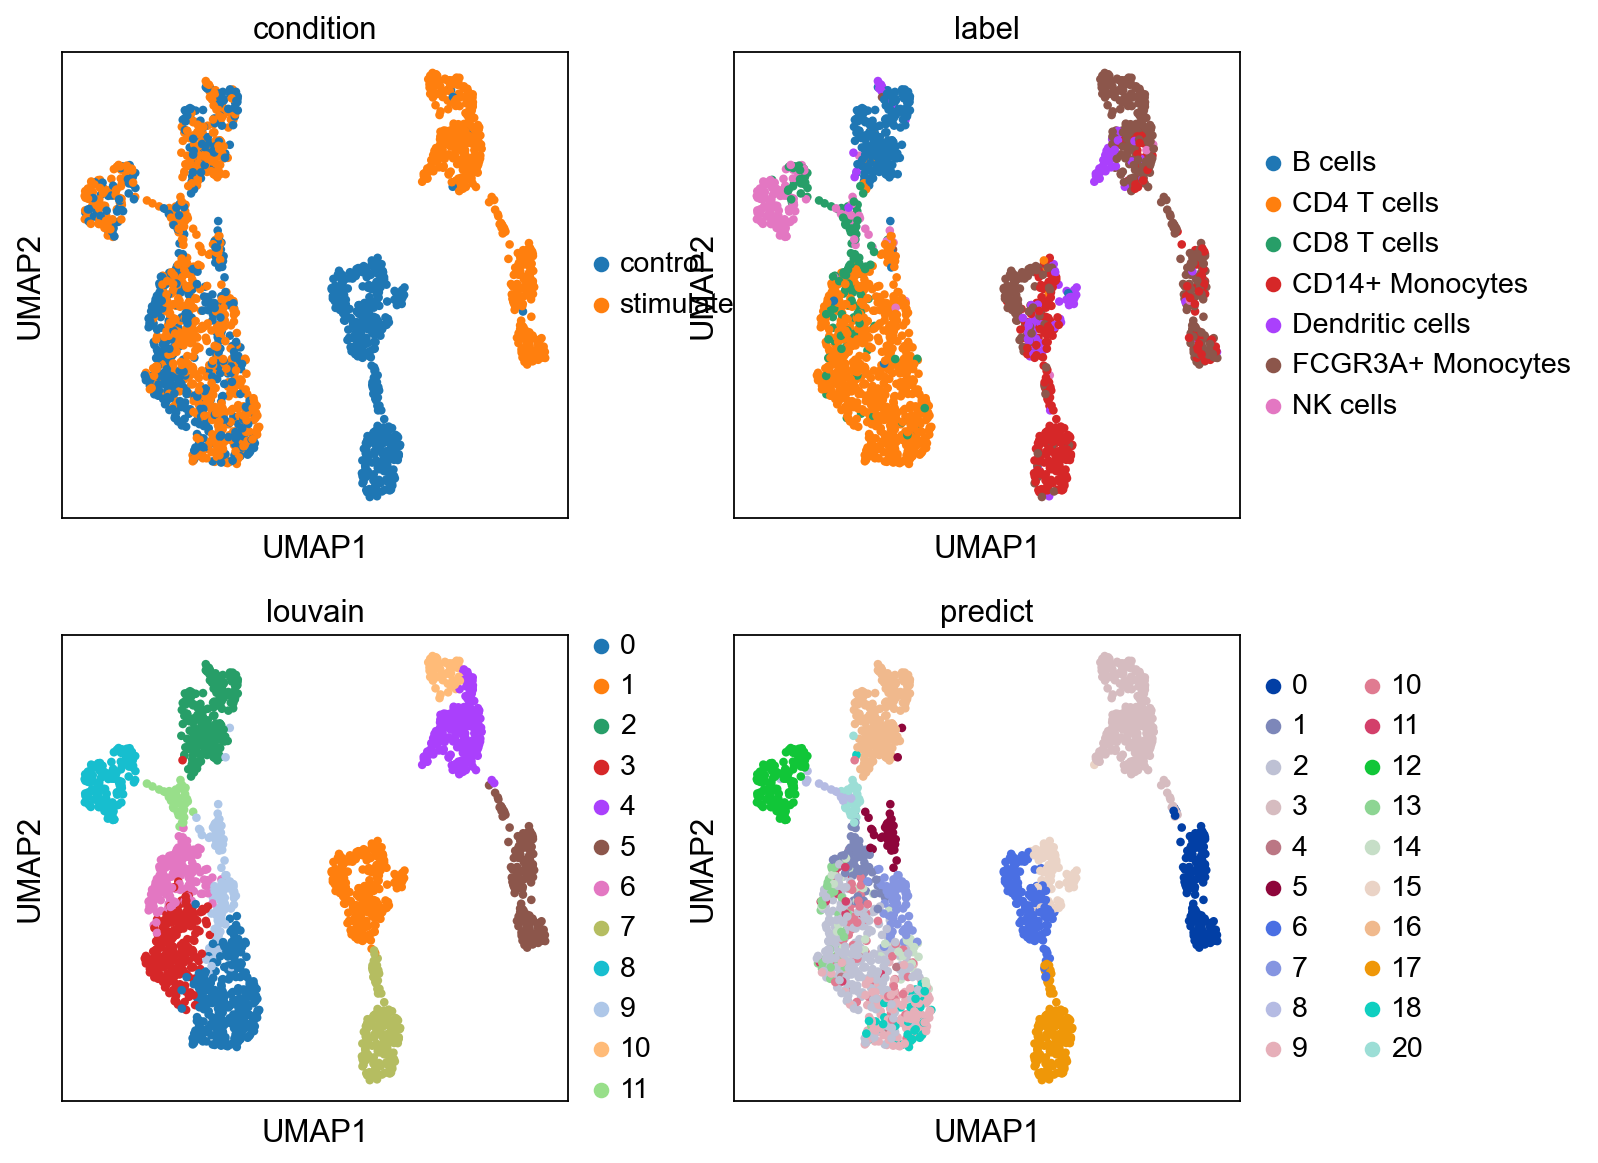

In [66]:
#fig, ax = plt.subplots(1,1)
sc.pl.umap(bdata, ncols=2, 
           color=[
               #"cell_type",
               "condition",
               "label",
               "louvain",
               "predict",
           ],
           #title="PBMCs (Kang): UMAP (pca)", 
           #save="_Kang_pca_umap.png",
           #show=True,
           #ax=ax,
          )


In [112]:
reload(Mb0)
model = Mb0.VAE_Dirichlet_GMM_TypeB1602zC(
    nx=adata.n_vars,
    nz=12,
    nw=12,
    #nz=8,
    #nw=8,
    #nclasses=labels.shape[1]*3,
    nclasses=labels.shape[1]*4,
    concentration=1e0,
    dropout=0.1,
    bn=True,
    reclosstype="mse",
    #reclosstype="Gauss",
    restrict_w=True,
    restrict_z=True,
    nc1=conditions.shape[1],
    #learned_prior=False,
    learned_prior=True,
    positive_rec=True,
)
model.apply(init_weights)
print(model.__class__)

True
<class 'gmmvaeBeta00.VAE_Dirichlet_GMM_TypeB1602zC'>


In [119]:
Train.basicTrainLoopCond(
    model,
    data_loader,
    test_loader,
    num_epochs=25,
    lrs = [
        1e-4,
        1e-3,
        1e-3,
        1e-3,
        1e-4,
        1e-5,
    ],
    report_interval=0,
    wt=0,
)
r,p,s = ut.estimateClusterImpurityLoop(model, test_data, test_labels, "cuda", )
print(p,r,s)
r = r[r>=0]
s = s[s>=0]
print((r*s).sum().item() / s.sum().item(), r.mean().item())

epoch's lr =  0.0001
epoch's lr =  0.001
epoch's lr =  0.001
epoch's lr =  0.001
epoch's lr =  0.0001
epoch's lr =  1e-05
done training
[ 0.  2.  2.  5.  5.  1.  2.  2.  3.  2.  2.  2.  2.  2.  2.  6. -1.  2.
  2. -1.  2.  2.  2.  2.  2. -1.  6.  2.] [ 0.86610879  0.94186047  0.66666667  0.64423077  0.60335196  0.88535032
  0.95        1.          0.75        0.7721519   1.          1.
  0.97945205  0.84693878  0.97321429  1.         -1.          1.
  0.54166667 -1.          1.          1.          0.84210526  1.
  0.86538462 -1.          0.51086957  1.        ] [239.  86.  12. 312. 358. 157.  40.  14.  36.  79.   4.   6. 146.  98.
 112.  65.  -1.   1.  24.  -1.  18.   9.  38.   1.  52.  -1.  92.   1.]
0.7845 0.8655740834633181


In [120]:
model.cpu()
model.eval()
output = model(test_data, )
bdata.obs["predict"] =  output["q_y"].argmax(-1).detach().numpy().astype(str)
#bdata.obs["predict"] = test_enc_labels.inverse_transform(
#    output["q_y"].argmax(-1).detach().numpy(),
#)
bdata.obsm["mu_z"] = output["mu_z"].detach().numpy()
bdata.obsm["z"] = output["z"].detach().numpy()
bdata.obsm["mu_w"] = output["mu_w"].detach().numpy()
bdata.obsm["w"] = output["w"].detach().numpy()
rec = output["rec"].detach()
del output
sc.pp.neighbors(bdata, use_rep="mu_z",)
sc.pp.pca(bdata,)
sc.tl.umap(bdata,)
sc.tl.louvain(bdata,)

/home/ykolb/mambaforge/envs/torch/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/ykolb/mambaforge/envs/torch/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/ykolb/mambaforge/envs/torch/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/ykolb/mambaforge/envs/torch/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


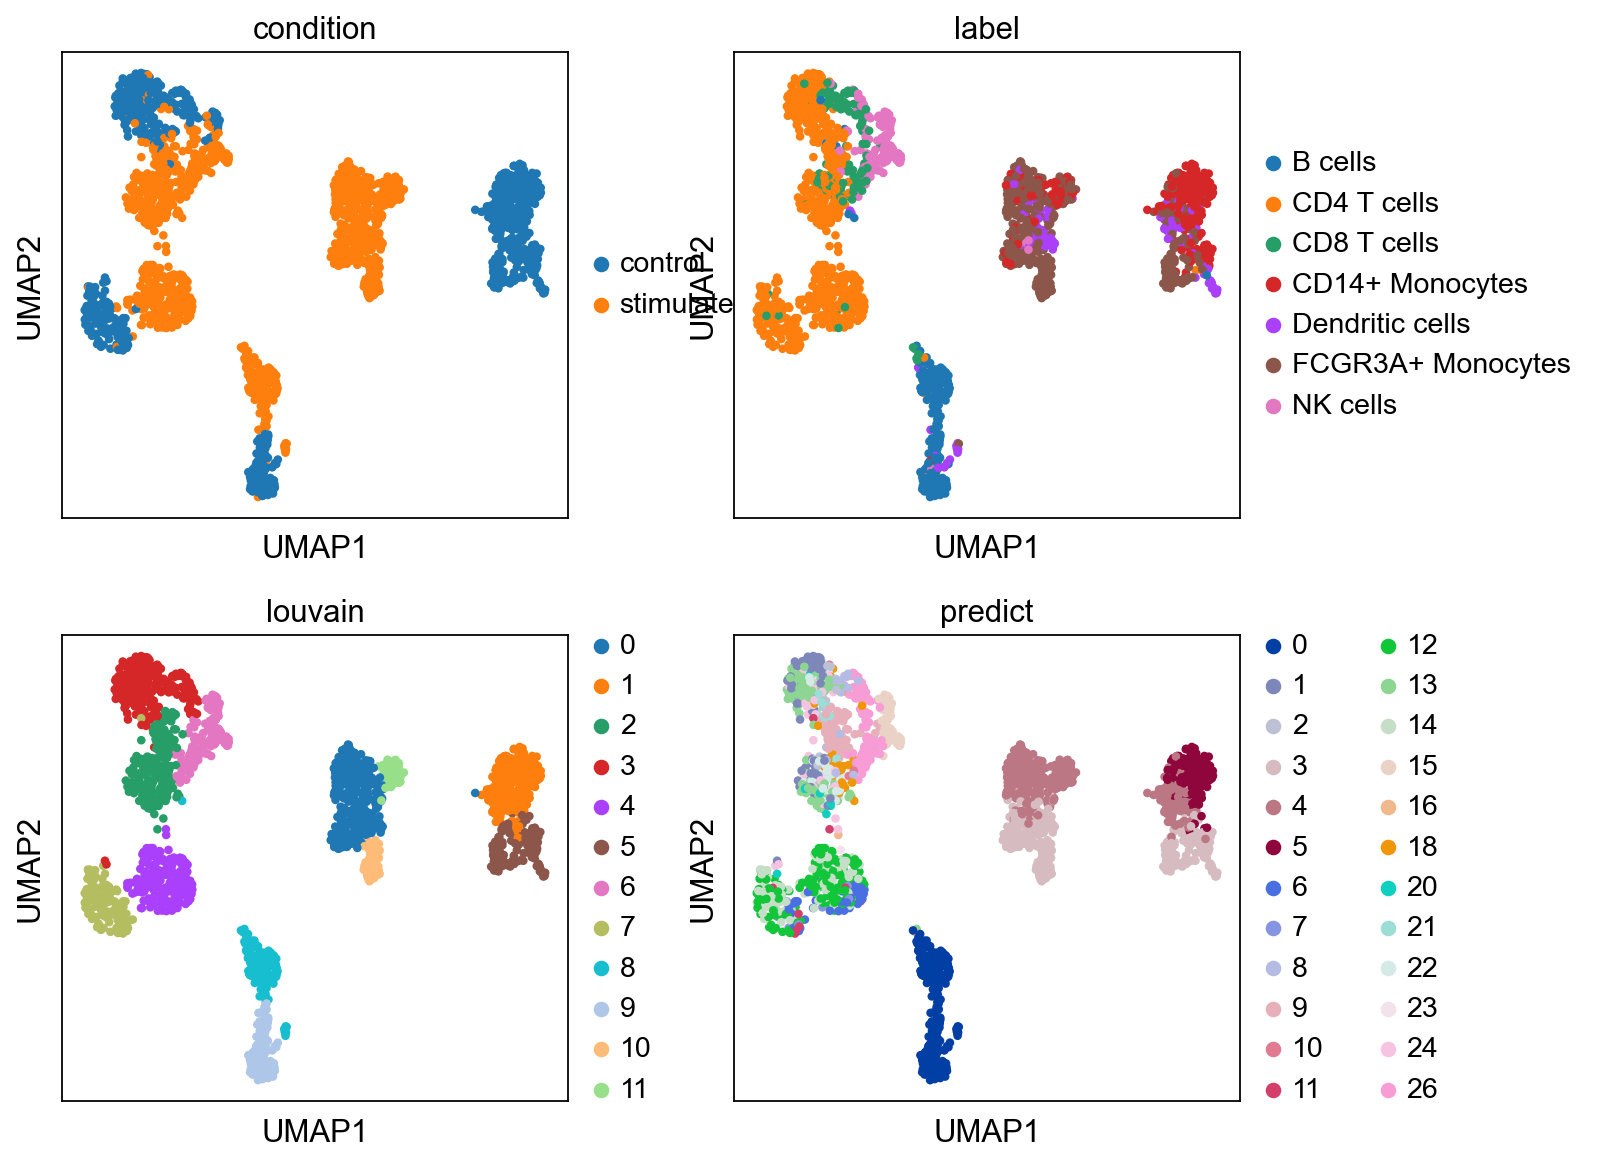

In [121]:
#fig, ax = plt.subplots(1,1)
sc.pl.umap(bdata, ncols=2, 
           color=[
               #"cell_type",
               "condition",
               "label",
               "louvain",
               "predict",
           ],
           #title="PBMCs (Kang): UMAP (pca)", 
           #save="_Kang_pca_umap.png",
           #show=True,
           #ax=ax,
          )


In [118]:
test_data.max()

tensor(6.2653)

In [125]:
#0.82
model = Mb0.VAE_Dirichlet_GMM_TypeB1602zC2(
    nx=adata.n_vars,
    #nz=24,
    #nw=24,
    #nz=8,
    #nw=8,
    #nz=48,
    #nw=48,
    nz=12,
    nw=12,
    #nclasses=labels.shape[1]*3,
    nclasses=labels.shape[1]*4,
    concentration=1e0,
    #dropout=0.15,
    dropout=0.1,
    bn=True,
    #reclosstype="mse",
    reclosstype="Gauss",
    restrict_w=True,
    restrict_z=True,
    nc1=conditions.shape[1],
    #learned_prior=False,
    learned_prior=True,
    positive_rec=True,
)
model.apply(init_weights)
model.load_state_dict(
    torch.load(
        "./results/temp_gmmvaezc2_kang_us_0821669118246.07834_zlIlykcm_state.pt",
    ),
)
print(model.__class__)
r,p,s = ut.estimateClusterImpurityLoop(model, test_data, test_labels, "cuda", )
print(p,r,s)
r = r[r>=0]
s = s[s>=0]
print((r*s).sum().item() / s.sum().item(), r.mean().item())

<class 'gmmvaeBeta00.VAE_Dirichlet_GMM_TypeB1602zC2'>
[6. 1. 2. 1. 2. 2. 2. 2. 2. 3. 4. 2. 2. 0. 2. 6. 0. 3. 2. 3. 5. 2. 2. 5.
 5. 5. 2. 5.] [1.         0.63265306 0.96875    0.75925926 1.         0.96153846
 0.97959184 0.5952381  0.96774194 0.56410256 0.96078431 0.95918367
 0.96923077 0.9296875  0.96610169 0.77586207 0.85263158 0.6
 0.86111111 0.76086957 0.42372881 0.85294118 1.         0.81415929
 0.68269231 0.97826087 0.92753623 0.68888889] [ 49.  98.  32. 162.  43.  26.  98.  42.  31.  39.  51.  98.  65. 128.
  59.  58.  95.  65.  36.  46. 118.  68.  24. 113. 104. 138.  69.  45.]
0.822 0.836876609616411


/home/ykolb/mambaforge/envs/torch/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/ykolb/mambaforge/envs/torch/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/ykolb/mambaforge/envs/torch/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/ykolb/mambaforge/envs/torch/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


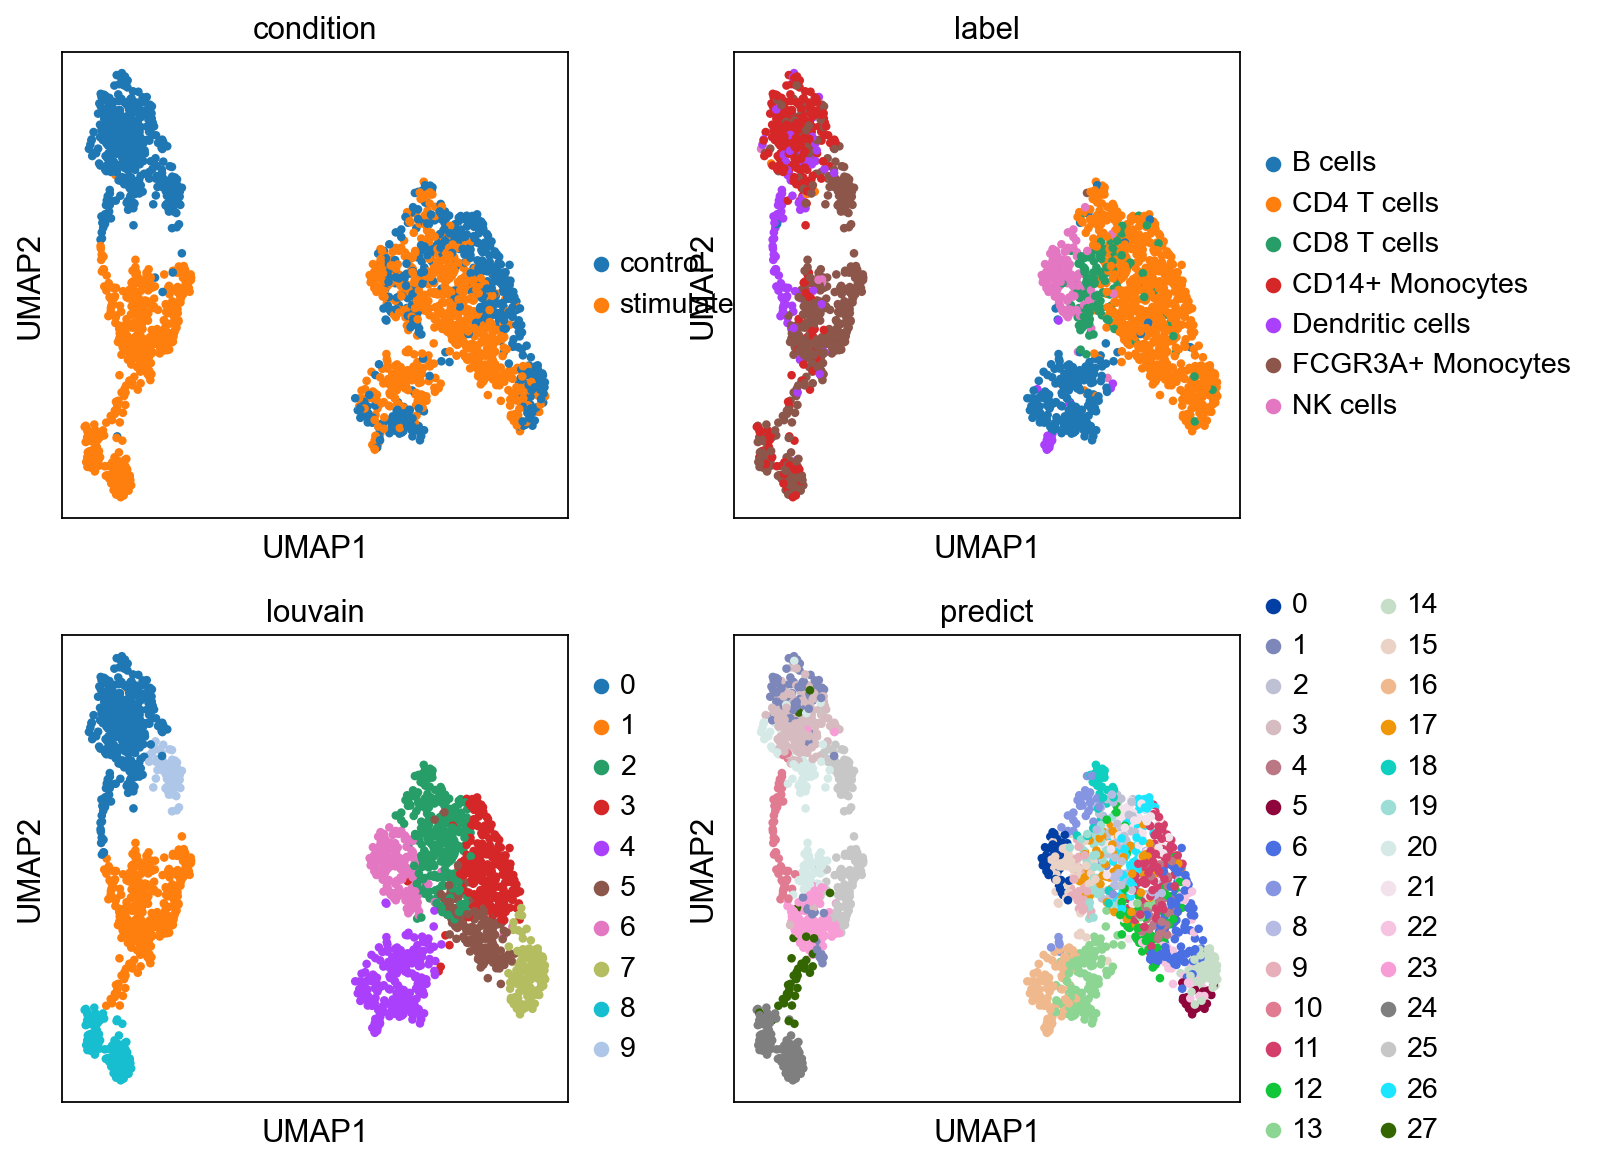

In [126]:
model.cpu()
model.eval()
output = model(test_data, )
bdata.obs["predict"] =  output["q_y"].argmax(-1).detach().numpy().astype(str)
#bdata.obs["predict"] = test_enc_labels.inverse_transform(
#    output["q_y"].argmax(-1).detach().numpy(),
#)
bdata.obsm["mu_z"] = output["mu_z"].detach().numpy()
bdata.obsm["z"] = output["z"].detach().numpy()
bdata.obsm["mu_w"] = output["mu_w"].detach().numpy()
bdata.obsm["w"] = output["w"].detach().numpy()
rec = output["rec"].detach()
del output
sc.pp.neighbors(bdata, use_rep="mu_z",)
sc.pp.pca(bdata,)
sc.tl.umap(bdata,)
sc.tl.louvain(bdata,)
#fig, ax = plt.subplots(1,1)
sc.pl.umap(bdata, ncols=2, 
           color=[
               #"cell_type",
               "condition",
               "label",
               "louvain",
               "predict",
           ],
           #title="PBMCs (Kang): UMAP (pca)", 
           #save="_Kang_pca_umap.png",
           #show=True,
           #ax=ax,
          )